In [159]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor, Pool

import shap

import warnings
warnings.filterwarnings('ignore')

def plot_dist(data, i, limit = np.inf):
    
    df = data[data[i] < limit].copy()
    
    plt.figure(figsize = (9, 4))
    sns.distplot(df[i], kde = False, bins = 40, hist_kws = {'edgecolor' : 'black', 'linewidth' : 1})
    plt.title('Distribution of ' + i)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()  
 
    
def fit_sm_OLS(data):
    
    y_name = data.filter(like = 'Ár').columns[0]
    
    Y = data[y_name].copy()
    X = data.drop(y_name, 1).copy()
    X = sm.add_constant(X)
    
    model = sm.OLS(Y, X)
    results = model.fit()
    
    return results

def OLS_results(ols_model, name_of_model = ''):
    
    p_ = ols_model.pvalues
    p_insignificant = p_[p_ > 0.05]
    p_insignificant = p_insignificant.index.tolist()

    r2 = ols_model.rsquared
    r2_adj = ols_model.rsquared_adj

    feat = len(p_.index.tolist())
    insig_feat = len(p_insignificant)
    
    return pd.DataFrame({'Model' : name_of_model, 'r2' : r2, 'r2 adj.' : r2_adj, 'features num' : feat, 
                         'insig. feat num' : insig_feat, 'insig. feat' : [', '.join(p_insignificant)]})


def mean_absolute_percentage_error(actual, pred): 
    return np.mean(np.abs((actual - pred) / actual)) * 100

def evaluate_model(model_name, model, X, y):
    
    predictions = model.predict(X)
    feat = model.n_features_in_

    R2 = r2_score(y, predictions)
    
    return pd.DataFrame({'Model' : model_name, 'r2' : R2, 'features num' : feat}, index = [0])
    

def plot_predictions(model, x, y, title):
    
    plt.figure(figsize = (9, 5))
    sns.scatterplot(x = y, y = model.predict(x), s = 20, size = 3/4, edgecolor = 'k', linewidth = 1/3, color = 'blue', legend = False)
    sns.lineplot([y.min(), y.max()], [y.min(), y.max()], color = 'black', linewidth = 1)
    plt.title(title + '\n')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.show()
    
    
def explain_single_prediction(NUM, expected_value, X, shap_values, waterfall = True):
    
    if waterfall:
        return shap.waterfall_plot(shap.Explanation(values = shap_values[NUM], 
                                                    base_values = expected_value, 
                                                    data = X.iloc[NUM],  
                                                    feature_names = X.columns.tolist()))
    
    else:
        return shap.force_plot(expected_value, shap_values[NUM], X.iloc[NUM])

In [2]:
data = pd.read_csv('data/haz_hirdetesek_modeling.csv.gz', compression='gzip')

### Build simple OLS regression models

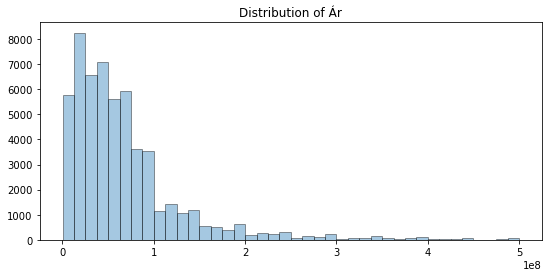

In [3]:
plot_dist(data, 'Ár')

In [23]:
data['Log Ár'] = np.log(data['Ár'])
data['Log Alapterület'] = np.log(data['Alapterület'])
data['Log Telekterület'] = np.log(data['Telekterület'])

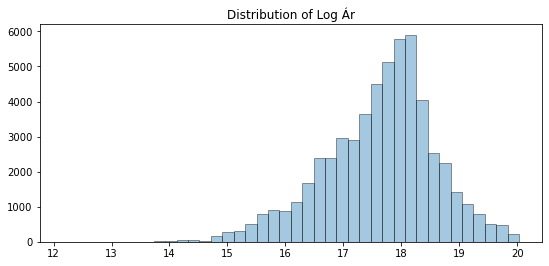

In [8]:
plot_dist(data, 'Log Ár')

In [25]:
regression_data = data.copy()

In [26]:
# based on distribution from Analysis notebook

regression_data['Építés éve'].fillna(1970, inplace = True) 
regression_data['Épület szintjei'].fillna(1, inplace = True)

In [46]:
categoricals = ['Ingatlan állapota', 'Komfort', 'Fűtés', 'Fürdő és WC', 'Kilátás', 'Tetőtér', 'Parkolás', 'Típus', 'Megye']
categoricals_with_kerulet = ['Ingatlan állapota', 'Komfort', 'Fűtés', 'Fürdő és WC', 'Kilátás', 'Tetőtér', 'Parkolás', 'Típus', 'Megye', 'Kerület']

numerics = ['Építés éve', 'Épület szintjei', 'Alapterület', 'Telekterület', 'Szoba']
numerics_ln = ['Építés éve', 'Épület szintjei', 'Log Alapterület', 'Log Telekterület', 'Szoba']

created = ['Csendes övezet', 'Balaton közelében', 'Megyeszékhely']

Regression data frames

In [47]:
level_model = regression_data[['Ár'] + numerics + categoricals]
level_model_with_created = regression_data[['Ár'] + numerics + categoricals + created]
level_model_with_created_kerulet = regression_data[['Ár'] + numerics + categoricals_with_kerulet + created]

log_model = regression_data[['Log Ár'] + numerics_ln + categoricals]
log_model_with_created = regression_data[['Log Ár'] + numerics_ln + categoricals + created]
log_model_with_created_kerulet = regression_data[['Log Ár'] + numerics_ln + categoricals_with_kerulet + created]


level_model = pd.get_dummies(level_model, columns = categoricals, prefix_sep = ' = ')
log_model = pd.get_dummies(log_model, columns = categoricals, prefix_sep = ' = ')

level_model_with_created = pd.get_dummies(level_model_with_created, columns = categoricals, prefix_sep = ' = ')
log_model_with_created = pd.get_dummies(log_model_with_created, columns = categoricals, prefix_sep = ' = ')

level_model_with_created_kerulet = pd.get_dummies(level_model_with_created_kerulet, columns = categoricals_with_kerulet, prefix_sep = ' = ')
log_model_with_created_kerulet = pd.get_dummies(log_model_with_created_kerulet, columns = categoricals_with_kerulet, prefix_sep = ' = ')

Apply OLS regression

In [48]:
%%time

level_model_OLS = fit_sm_OLS(level_model)
log_model_OLS = fit_sm_OLS(log_model)

level_model_with_created_OLS = fit_sm_OLS(level_model_with_created)
log_model_with_created_OLS = fit_sm_OLS(log_model_with_created)

level_model_with_created_kerulet_OLS = fit_sm_OLS(level_model_with_created_kerulet)
log_model_with_created_kerulet_OLS = fit_sm_OLS(log_model_with_created_kerulet)

Wall time: 5.6 s


Compare

In [50]:
ols_results_comparison = pd.concat(
                                      [OLS_results(level_model_OLS, 'Level model'),
                                       OLS_results(level_model_with_created_OLS, 'Level model with created features'),
                                       OLS_results(level_model_with_created_kerulet_OLS, 'Level model with created features & kerület'),
                                       OLS_results(log_model_OLS, 'Log model'),
                                       OLS_results(log_model_with_created_OLS, 'Log model with created features'),
                                       OLS_results(log_model_with_created_kerulet_OLS, 'Log model with created features & kerület')]
                                  )

ols_results_comparison.sort_values('r2')

,Model,r2,r2 adj.,features num,insig. feat num,insig. feat
0,Level model,0.603900,0.603416,71,8,"Ingatlan állapota = felújított, Komfort = dupl..."
0,Level model with created features,0.613378,0.612885,74,8,"Ingatlan állapota = felújított, Komfort = dupl..."
0,Level model with created features & kerület,0.668241,0.667699,95,10,"Ingatlan állapota = felújított, Fűtés = cserép..."
0,Log model,0.725091,0.724756,71,6,"Ingatlan állapota = felújított, Fűtés = cserép..."
0,Log model with created features,0.749594,0.749274,74,6,"Csendes övezet, Ingatlan állapota = felújított..."
0,Log model with created features & kerület,0.756818,0.756420,95,14,"Épület szintjei, Csendes övezet, Ingatlan álla..."


### Build black box ML models for Price

In [76]:
catboost_data = data[['Ár'] + numerics + categoricals_with_kerulet]

In [80]:
for i in categoricals_with_kerulet:
    catboost_data[i].fillna('NA', inplace = True)

In [81]:
X = catboost_data.drop(['Ár'], 1).copy()
y = catboost_data['Ár'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state = 20202020)

In [111]:
%%time

cat_params = {'learning_rate': [0.2],
              'l2_leaf_reg': [1],
              'subsample': [.8],
              'rsm' : [1/2],
              'max_depth': [9], # up to 16 
              'grow_policy': ['Lossguide'],
              'min_data_in_leaf' : [9], 
              'max_leaves' : [25],
              'iterations' : [2000]} 

cat = CatBoostRegressor(random_state = 20202020, one_hot_max_size = 30, eval_metric = 'RMSE', objective = 'RMSE',
                        cat_features = categoricals_with_kerulet, verbose = 0)

GRID_cat = GridSearchCV(cat, param_grid = cat_params, cv = 3, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
GRID_cat.fit(X_train, y_train)

Wall time: 1min 37s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001BDBC538940>,
             n_jobs=-1,
             param_grid={'grow_policy': ['Lossguide'], 'iterations': [2000],
                         'l2_leaf_reg': [1], 'learning_rate': [0.2],
                         'max_depth': [9], 'max_leaves': [25],
                         'min_data_in_leaf': [9], 'rsm': [0.5],
                         'subsample': [0.8]},
             scoring='neg_root_mean_squared_error')

In [112]:
catb_results = evaluate_model('CatBoost', GRID_cat.best_estimator_, X_test, y_test)

In [113]:
catb_results

,Model,r2,features num
0,CatBoost,0.789695,15


#### Compare all

In [114]:
pd.concat([ols_results_comparison, catb_results])[['Model', 'r2', 'features num']]

,Model,r2,features num
0,Level model,0.603900,71
0,Level model with created features,0.613378,74
0,Level model with created features & kerület,0.668241,95
0,Log model,0.725091,71
0,Log model with created features,0.749594,74
0,Log model with created features & kerület,0.756818,95
0,CatBoost,0.789695,15


Level model of CatBoost is better than OLS regressions using logarithm

### Explain CatBoost model

In [121]:
results = data[['Ár', 'URL'] + numerics + categoricals_with_kerulet].copy()
results['Ár becsült'] = GRID_cat.best_estimator_.predict(X)

In [123]:
shap.initjs()

In [124]:
train_pool = Pool(X_train, y_train, cat_features = categoricals_with_kerulet)

In [125]:
%%time

shap_values = GRID_cat.best_estimator_.get_feature_importance(train_pool, type = 'ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

Wall time: 39min 44s


In [131]:
# with open('data/shap_values.pkl', 'wb') as pkl:
#     pickle.dump(shap_values, pkl)

In [132]:
with open('data/shap_values.pkl', 'rb') as pkl:
    shap_values = pickle.load(pkl)

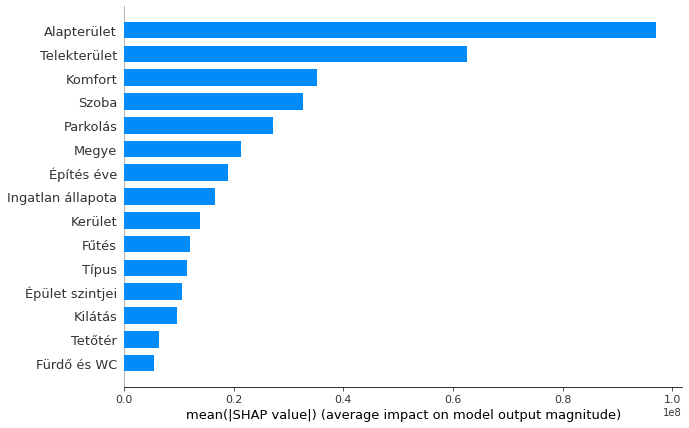

In [126]:
shap.summary_plot(shap_values, X_train, plot_type = 'bar', plot_size = (10, 7), alpha = 1/2, max_display = 20)

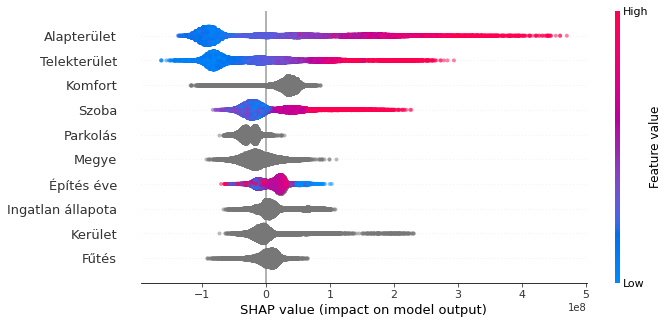

In [137]:
shap.summary_plot(shap_values, X_train, plot_type = 'dot', plot_size = (10, 5), alpha = 1/2, max_display = 10)

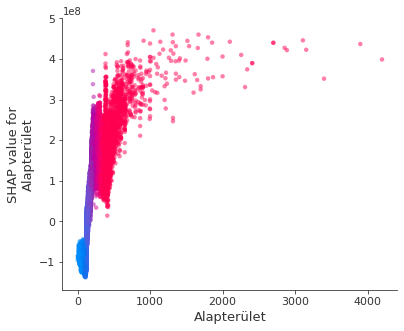

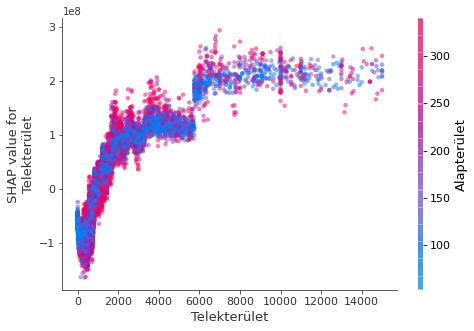

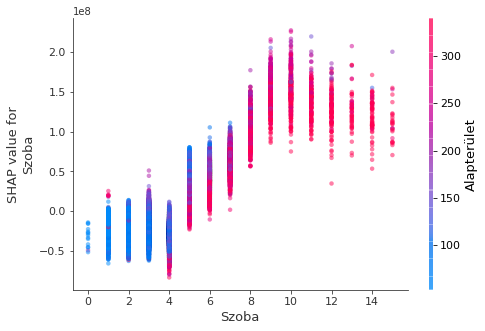

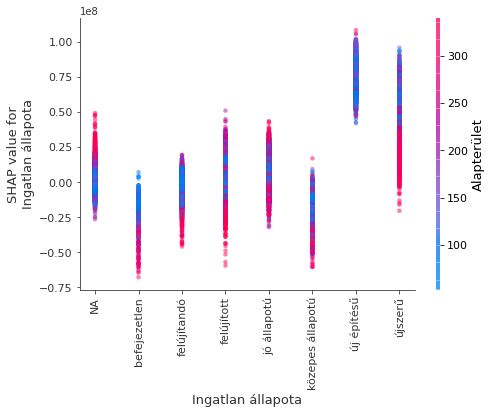

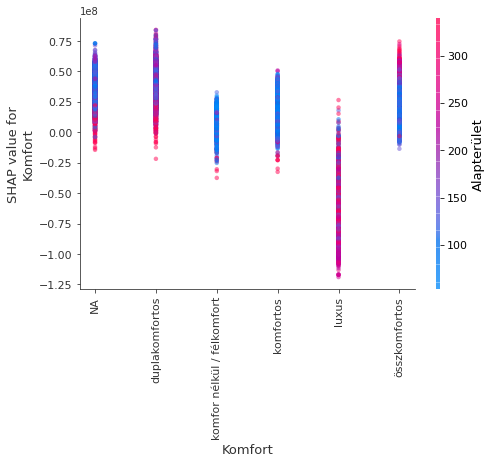

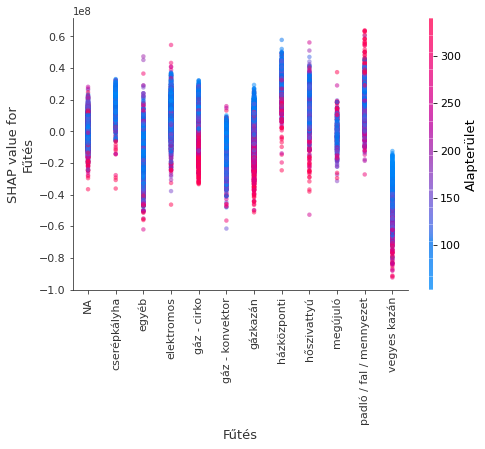

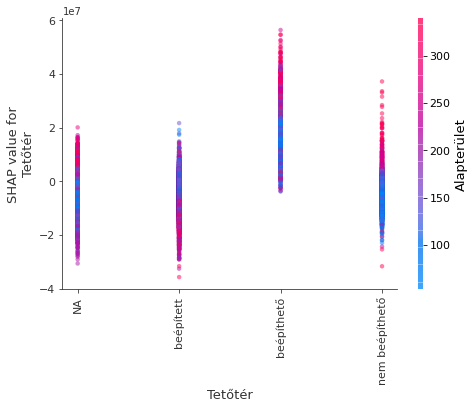

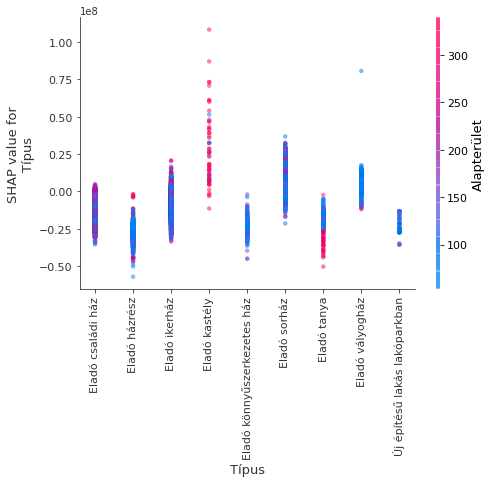

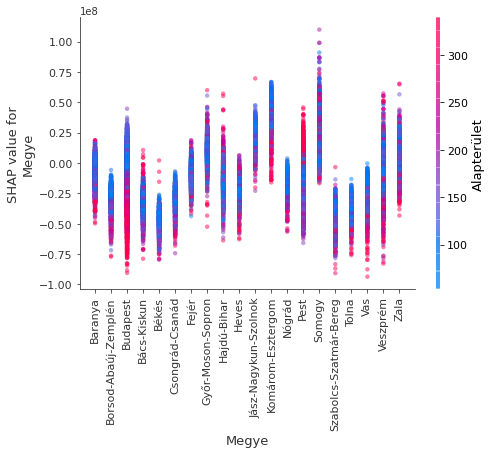

In [140]:
check_cols = ['Alapterület', 'Telekterület', 'Szoba', 'Ingatlan állapota', 'Komfort',
              'Fűtés', 'Tetőtér', 'Típus', 'Megye']

for name in check_cols:
    shap.dependence_plot(name, shap_values, X_train, dot_size = 20, alpha = 1/2, interaction_index = 'Alapterület')

Single prediction

In [200]:
# NUM = 902

# print('Prediction:', GRID_cat.best_estimator_.predict(X_train.iloc[NUM]))
# print('Actual:', y_train[NUM])

In [201]:
# explain_single_prediction(NUM, expected_value, X_train, shap_values, waterfall = False)

In [202]:
# explain_single_prediction(NUM, expected_value, X_train, shap_values, waterfall = True)

Feature statistics

In [209]:
# GRID_cat.best_estimator_.calc_feature_statistics(X_test, y_test, 'Alapterület')